In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

In [ ]:
def get_unique_parents(input_file):
    df = pd.read_csv(input_file, sep="\t")
    print("All:", len(df))
    unique_parents = df["reactants"].unique()
    print("Unique:", len(unique_parents))


get_unique_parents("dataset/finetune/VA_finetune.csv")
get_unique_parents("dataset/finetune/metatrans_finetune.csv")
get_unique_parents("dataset/finetune/LAGOM_finetune.csv")

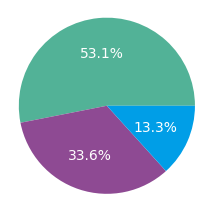

In [2]:
def source_analysis(csv_file, save_figure=None):
    plt.figure(figsize=(2.5, 2.5))

    df = pd.read_csv(csv_file)

    counts = df["source"].value_counts()

    colors = ["#52B297", "#8E4A93", "#009EE7", "#EF766E"]

    plt.pie(
        counts,
        autopct="%1.1f%%",
        colors=colors,
        textprops={"color": "white", "fontsize": 10},
    )
    plt.axis("equal")

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.svg", format="svg", bbox_inches="tight")

    plt.show()


after = "../dataset/curated_data/LAGOM_smiles_clean.csv"
source_analysis(after, "piechart")

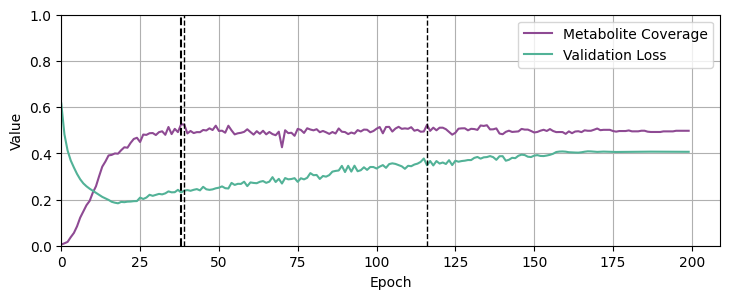

In [3]:
def plot_metrics_report(csv_file_path, save_figure):
    import pandas as pd
    import matplotlib.pyplot as plt
    import os

    data = pd.read_csv(csv_file_path, sep="\t")

    colour_scheme = ["#52B297", "#8E4A93", "#009EE7", "#EF766E"]

    epoch = data["epoch"]
    metabolite_coverage_score = data["metabolite_coverage_score"]
    validation_loss = data["validation_loss"]

    plt.figure(figsize=(8.5, 3))

    plt.plot(
        epoch,
        metabolite_coverage_score,
        label="Metabolite Coverage",
        color=colour_scheme[1],
    )
    plt.plot(epoch, validation_loss, label="Validation Loss", color=colour_scheme[0])

    plt.axvline(x=38, color="k", linestyle="--", linewidth=1.5)
    for e in [39, 116]:
        plt.axvline(x=e, color="k", linestyle="--", linewidth=1)  # 'k' for black

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)

    plt.xlim(left=0)

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.pdf", format="pdf", bbox_inches="tight")

    plt.show()


file = "../for_article/train_metrics/chemf_base_0_logged_train_metrics.csv"
plot_metrics_report(file, "metrics_chemf_0_dashed")

Proportion with value >= 100 <= 750: 0.9628243512974052
Mean met Da:  357.5015314262919
Mean drug Da:  322.2503691701832
Proportion with value >= 0.2: 0.9583428702220188
Mean similarity after: 0.6135747215260194
Mean child count: 1.8038256227758007


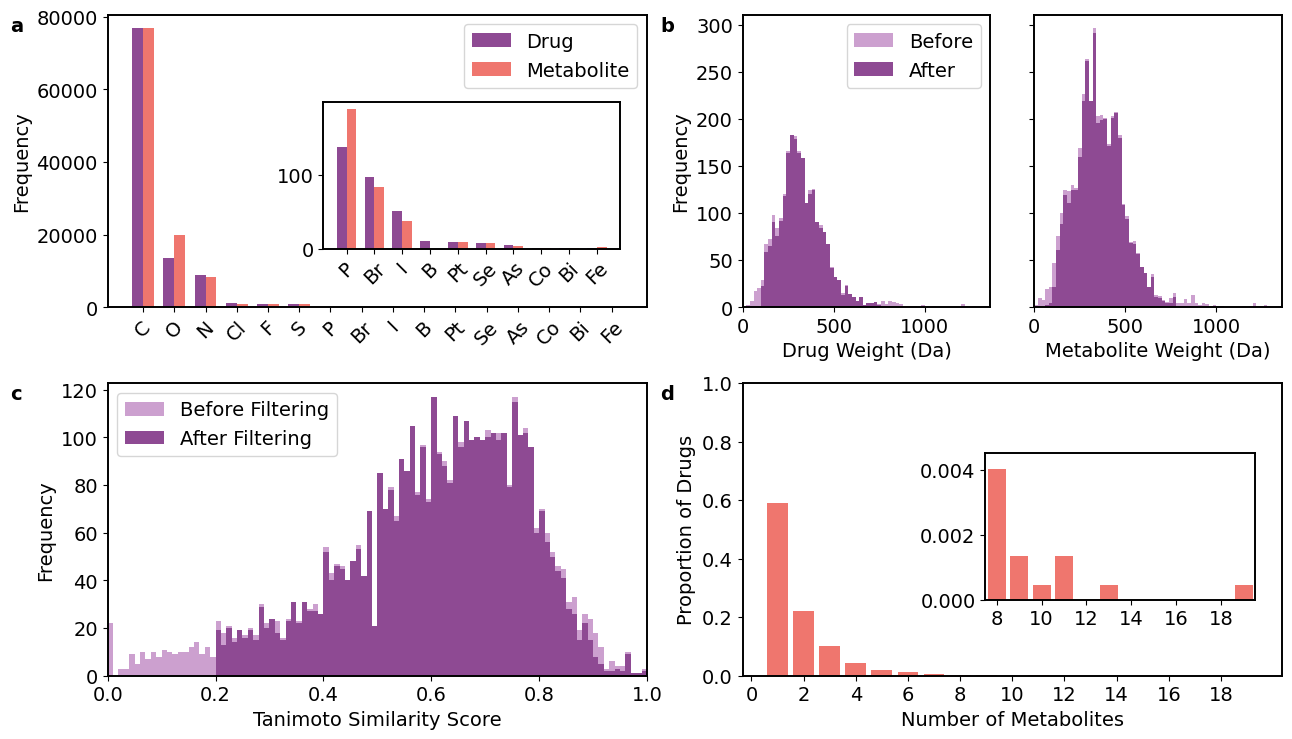

In [4]:
# --- 1. Font size parameter ---
fsize = 14

# --- 2. Data Paths ---
before = "../dataset/curated_data/LAGOM_smiles_before_filters.csv"
after = "../dataset/curated_data/LAGOM_smiles_clean.csv"


# --- 3. Data Processing ---
def define_atoms(molecule):
    mol = Chem.MolFromSmiles(molecule)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_counts = Counter(atoms)
    return atom_counts


def analyse_atoms(data, column):
    total_atoms_count = Counter()
    for molecule in data[column]:
        atom_counts = define_atoms(molecule)
        total_atoms_count.update(atom_counts)
    return total_atoms_count


# --- 4. Plotting Functions (all accept ax and fsize) ---
def plot_histogram(parent_atom_counts, child_atom_counts, ax, fsize):
    all_atoms = set(list(parent_atom_counts.keys()) + list(child_atom_counts.keys()))
    atom_data = [
        (atom, parent_atom_counts.get(atom, 0), child_atom_counts.get(atom, 0))
        for atom in all_atoms
    ]
    sorted_atoms = sorted(atom_data, key=lambda x: x[1], reverse=True)
    full_order, parent_counts, child_counts = zip(*sorted_atoms)
    full_order = list(full_order)
    bar_width = 0.35
    index = np.arange(len(full_order))
    ax.bar(index, parent_counts, bar_width, label="Drug", color="#8E4A93")
    ax.bar(
        index + bar_width, child_counts, bar_width, label="Metabolite", color="#EF766E"
    )
    ax.set_ylabel("Frequency", fontsize=fsize)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(full_order, rotation=45, fontsize=fsize)
    ax.legend(fontsize=fsize)
    ax.tick_params(axis="y", labelsize=fsize)
    # Inset for remaining atoms
    if len(full_order) > 6:
        remaining_atoms = full_order[6:]
        inset_ax = ax.inset_axes([0.4, 0.2, 0.55, 0.5])
        inset_index = np.arange(len(remaining_atoms))
        inset_parent_counts = [
            parent_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]
        inset_child_counts = [
            child_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]
        inset_ax.bar(inset_index, inset_parent_counts, bar_width, color="#8E4A93")
        inset_ax.bar(
            inset_index + bar_width, inset_child_counts, bar_width, color="#EF766E"
        )
        inset_ax.set_xticks(inset_index + bar_width / 2)
        inset_ax.set_xticklabels(remaining_atoms, rotation=45, fontsize=fsize)
        inset_ax.tick_params(labelsize=fsize)
        inset_ax.tick_params(axis="y", labelsize=fsize)

        for spine in inset_ax.spines.values():
            spine.set_linewidth(1.4)


def molecular_weight_analysis_2(dataset):
    unique_parents_smiles = set(dataset["parent_smiles"])
    unique_child_smiles = set(dataset["child_smiles"])
    metabolite_weights, parent_weights = [], []
    for smiles in unique_parents_smiles:
        parent_weights.append(Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles)))
    for smiles in unique_child_smiles:
        metabolite_weights.append(Descriptors.ExactMolWt(Chem.MolFromSmiles(smiles)))
    return metabolite_weights, parent_weights


def plot_molecular_weights_subfig(before_file, after_file, axes, fsize):
    df_before = pd.read_csv(before_file)
    df_after = pd.read_csv(after_file)
    metabolite_weights_before, parent_weights_before = molecular_weight_analysis_2(
        df_before
    )
    proportion = np.mean(
        (np.array(metabolite_weights_before) >= 100)
        & (np.array(metabolite_weights_before) <= 750)
    )
    print("Proportion with value >= 100 <= 750:", proportion)
    metabolite_weights_after, parent_weights_after = molecular_weight_analysis_2(
        df_after
    )
    print("Mean met Da: ", np.mean(metabolite_weights_after))
    print("Mean drug Da: ", np.mean(parent_weights_after))
    x_range = (0, 1360)
    bin_width = 20
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    axes[0].hist(
        parent_weights_before, bins=bins, color="#CCA0CF", alpha=1, label="Before"
    )
    axes[0].hist(
        parent_weights_after, bins=bins, color="#8E4A93", alpha=1, label="After"
    )
    axes[0].set_xlabel("Drug Weight (Da)", fontsize=fsize)
    axes[0].set_ylabel("Frequency", fontsize=fsize)
    axes[0].legend(fontsize=fsize)
    axes[0].set_xlim(x_range)
    axes[0].tick_params(axis="x", labelsize=fsize)
    axes[0].tick_params(axis="y", labelsize=fsize)
    axes[1].hist(
        metabolite_weights_before, bins=bins, color="#CCA0CF", alpha=1, label="Before"
    )
    axes[1].hist(
        metabolite_weights_after, bins=bins, color="#8E4A93", alpha=1, label="After"
    )
    axes[1].set_xlabel("Metabolite Weight (Da)", fontsize=fsize)
    axes[1].set_ylabel("Frequency", fontsize=fsize)
    axes[1].set_xlim(x_range)
    axes[1].tick_params(axis="x", labelsize=fsize)
    axes[1].tick_params(axis="y", labelsize=fsize)
    max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(0, max_y)
    axes[1].set_ylim(0, max_y)


def fingerprint_similarity(csv_file):
    df = pd.read_csv(csv_file)
    parent_smiles = df["parent_smiles"].tolist()
    metabolite_smiles = df["child_smiles"].tolist()
    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]
    parent_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in parent_mol
    ]
    metabolite_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in metabolite_mol
    ]
    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        s = DataStructs.TanimotoSimilarity(parent_fps[i], metabolite_fps[i])
        fingerprint_similarities.append(s)
    return fingerprint_similarities


def plot_fingerprint_similarity(csv_file_before, csv_file_after, ax, fsize):
    similarity_before = fingerprint_similarity(csv_file_before)
    proportion = np.mean(np.array(similarity_before) >= 0.2)
    print("Proportion with value >= 0.2:", proportion)
    similarity_after = fingerprint_similarity(csv_file_after)
    print("Mean similarity after:", np.mean(similarity_after))
    bins = np.arange(0, 1.01, 0.01)
    ax.hist(
        similarity_before, bins=bins, color="#CCA0CF", alpha=1, label="Before Filtering"
    )
    ax.hist(
        similarity_after, bins=bins, color="#8E4A93", alpha=1, label="After Filtering"
    )
    ax.set_xlabel("Tanimoto Similarity Score", fontsize=fsize)
    ax.set_ylabel("Frequency", fontsize=fsize)
    ax.set_xlim(0, 1)
    ax.legend(fontsize=fsize)
    ax.tick_params(axis="both", labelsize=fsize)


def number_of_children_zoom(csv, ax, fsize):
    df = pd.read_csv(csv)
    child_counts = df["parent_smiles"].value_counts()
    mean_child_count = child_counts.mean()
    print("Mean child count:", mean_child_count)
    occurrence_summary = child_counts.value_counts().sort_index()
    number_of_children_list = []
    frequency_list = []
    for number_of_children, frequency in occurrence_summary.items():
        number_of_children_list.append(number_of_children)
        frequency_list.append(frequency)
    total_parents = sum(frequency_list)
    normalized_frequencies = [freq / total_parents for freq in frequency_list]
    ax.bar(number_of_children_list, normalized_frequencies, color="#ef766e")
    ax.set_xlabel("Number of Metabolites", fontsize=fsize)
    ax.set_ylabel("Proportion of Drugs", fontsize=fsize)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(0, max(number_of_children_list) + 1, 2))
    ax.tick_params(axis="both", labelsize=fsize)
    inset_ax = ax.inset_axes([0.45, 0.26, 0.5, 0.5])
    xs = [x for x in number_of_children_list if x > 7]
    ys = [f for x, f in zip(number_of_children_list, normalized_frequencies) if x > 7]
    if xs:
        inset_ax.bar(xs, ys, color="#ef766e")
        inset_ax.set_xlim(7.5, max(xs) + 0.5)
        inset_ax.set_ylim(0, 0.0045)
        inset_ax.set_xticks(range(8, max(xs) + 1, 2))
    for label in inset_ax.get_xticklabels():
        label.set_fontsize(fsize)
    for label in inset_ax.get_yticklabels():
        label.set_fontsize(fsize)
    inset_ax.tick_params(axis="both", labelsize=fsize)

    for spine in inset_ax.spines.values():
        spine.set_linewidth(1.4)


# --- Data loading and analysis ---
data_before = pd.read_csv(before)
data_after = pd.read_csv(after)
parent_atom_counts = analyse_atoms(data_before, "parent_smiles")
child_atom_counts = analyse_atoms(data_before, "child_smiles")

# --- The 2x2 main figure ---
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))

# a)
plot_histogram(parent_atom_counts, child_atom_counts, ax=axs[0, 0], fsize=fsize)

# b) Subfigure in itself
gs_b = axs[0, 1].get_gridspec()
axs[0, 1].remove()  # Remove the blank placeholder
ax_b0 = fig.add_subplot(gs_b[0, 1].subgridspec(1, 2)[0])
ax_b1 = fig.add_subplot(gs_b[0, 1].subgridspec(1, 2)[1])
plot_molecular_weights_subfig(before, after, axes=[ax_b0, ax_b1], fsize=fsize)
ax_b1.set_ylabel("")
ax_b1.yaxis.set_tick_params(labelleft=False)

# c)
plot_fingerprint_similarity(before, after, ax=axs[1, 0], fsize=fsize)

# d)
number_of_children_zoom(after, ax=axs[1, 1], fsize=fsize)

# --- Letters a-d ---
labels = ["a", "b", "c", "d"]

label_coords = [
    [0.01, 0.97],
    [0.51, 0.97],
    [0.01, 0.48],
    [0.51, 0.48],
]

for label, (x, y) in zip(labels, label_coords):
    fig.text(x, y, label, fontsize=fsize, fontweight="bold", ha="left", va="top")

all_axes = [axs[0, 0], ax_b0, ax_b1, axs[1, 0], axs[1, 1]]
for ax in all_axes:
    for spine in ax.spines.values():
        spine.set_linewidth(1.4)

plt.tight_layout()

# --- Save ---
save_figure = "analysis_fig"
if save_figure is not None:
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{save_figure}.pdf", format="pdf", bbox_inches="tight")
plt.show()